### Quick Recap:
In the previous notebook, we preprocessed the data to have it set up for modeling. We identified 20 key words from each subreddit and interpreted a few of them to see what insights we can gain for the purpose of our problem statement and narrative.  
This is what we have interpreted so far:

* Many fans of Blackpink seem to have issues with the management of YG when it comes to handling Blackpink's promotion 
* Fans are frusterated over YG's lack of consistently promoting Blackpink throughout the year to capitalize on their popularity
* One the other hand, BigHit seems to be promoting Bts consistently throughout the year to capitalize on their current trend/success.

### Next Steps: 

In this notebook, we will begin by identifying the baseline accuracy score in order to use it as a comparison for future models' score. We will split the data for validation and training purposes. Ultimately testing and evaluating a Logistic Regression modeling technique to hopefully identify a production algorithm. Throughout this notebook, we will explain the process of the model and evaluate the outcome of the Logistic Regression model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
!ls

README.md assets    code      data


In [3]:
df = pd.read_csv('./data/bp_bts_df_clean.csv')
df.head()

,body,blackpink,char_count,word_count
0,this is something i can get behind and appreci...,1,1043,188
1,hold the fuck up rock songs i m considering...,1,75,12
2,what time and date is this in pdt 0 am is a b...,1,106,27
3,is there a list last year i remember they str...,1,84,16
4,as a blink i ll wait till mv dropped then i l...,1,149,33


## Baseline Accuracy:

Our baseline model accuracy is 51%. This means we will be correct 51% of the time if we choose that a comment is from the majority class subreddit, which in this case is the 'bangtan' subreddit.

In [4]:
round(df.blackpink.value_counts(normalize=True).max(),2)

0.51

Similar to the previous notebook, we will implement the CountVectorizer tool to have the words encored as integer counts in order to be used on a the Logistic Regression model. We will also split our data into 'X' and 'y'. The X is an object that consists of the predictor column, in this case the comments. The y will contain the binary classifier column, whether or not the comment belongs to a Blackpink subreddit or Bts subreddit.

In [5]:
X = df['body']
y = df['blackpink']

We will randomly split the data into training and test sets. This is done so we can train our model on the training set and then evaluate the performance of the model on unseen new data (the validation set).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [7]:
with open('./assets/stopwords.pkl','rb') as f:
    stopwords = pickle.load(f)

In [8]:
cvec = CountVectorizer(analyzer = "word",
                             stop_words = stopwords,
                             max_features = 100)

In [9]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [10]:
train_cvec_df = pd.DataFrame(X_train_cvec.todense(),   # b/c it is saved as a df...
                                    columns = cvec.get_feature_names())
test_cvec_df = pd.DataFrame(X_test_cvec.todense(), 
                            columns = cvec.get_feature_names())

## Naive Logistic Regression

We will do an initial attempt to classify the comments according to its' corresponding subreddits by utilizing the same CountVectorizer from before to the logistic regression model.

The logistic model will return a predicted score between 0 and 1 that indicates the accuracy percentage of whether the model correctly predicted a given comment being from the Blackpink or BTS subreddit.

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
logreg = LogisticRegression()

In [13]:
logreg.fit(train_cvec_df, y_train)

/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The naive Logistic Regression model gives us a test score of 61.6%. This is a 10% improvement over the baseline accuracy score; nevertheless, this is still not up to the par we want to have as our production model.

In [14]:
logreg.score(train_cvec_df, y_train)

0.6275974950185027

In [15]:
logreg.score(test_cvec_df, y_test)

0.6159265584970111

In [16]:
logreg_coef_df = pd.DataFrame(np.exp(logreg.coef_), columns=test_cvec_df.columns)

In [17]:
logreg_coef_df.head()

,actually,album,already,always,anyone,anything,army,around,back,best,...,video,wait,want,way,work,x200b,yeah,year,yes,yg
0,0.841327,0.541409,1.2109,0.85841,1.050837,0.958043,0.044344,1.298249,0.816463,0.9974,...,0.981027,1.255627,0.799601,0.870285,0.852856,0.880357,1.333738,1.053007,0.890081,22.662805


In [18]:
logreg_coef_df.rename(index={0:'odds'}, inplace=True)

In [19]:
logreg_coef_df.T.sort_values('odds',ascending=False).head(20)

,odds
yg,22.662805
concert,2.259355
tickets,1.777222
comeback,1.637255
ticket,1.473595
songs,1.459591
see,1.398562
group,1.375951
show,1.366175
maybe,1.358484


The top 20 important features (words) our naive Logistic Regression model provided us does not really give substantial information in respect to our problem statement beyond what we have already uncovered thus far. 
As a result, we will tune the hyperparameters of the CountVectorizer and try out different sets of these parameters on the Logistic Regression to get the best score result. In order to do this efficiently, we will implement pipeline and GridSearch, a tool that helps us to search for optimal sets of hyperparameters. This uses cross-validations internally to evaluate the performance of each set of given hyperparameters.

### Pipeline
---

Our pipeline will consist to two stages:
1. An instance of `CountVectorizer`
2. A `LogisticRegression` instance

In [20]:
pipe = Pipeline([
    ('cvec', CountVectorizer(analyzer='word', stop_words=stopwords)),
    ('lr', LogisticRegression())
    
])

### GridSearchCV on Logistic Regression

In [21]:
params = {
    'cvec__ngram_range' : [(1,1), (2,2)],
    'cvec__max_features': [5000, 5500, 6000, 6500], 
    'cvec__max_df' : [.98, 1.0],
    'cvec__min_df' : [1, 2]
    
}
gs = GridSearchCV(pipe, param_grid=params, cv=3)   #3 cv to save time.
gs.fit(X_train, y_train) # also does cv in the background
print(gs.best_score_)
print(gs.best_params_)

# Train score
print(f'Train accuracy score: {gs.score(X_train, y_train)}')

# Test score
print(f'Test accuracy score: {gs.score(X_test, y_test)}')

/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KeyboardInterrupt: 

Based on the grid search for our logistic regression model, it selected 6,500 features to be the best max features, chose 1 grams as the best ngram_range, 2 min as the best minimum words, and .98 for the max df as the best maximum threshold. However, the model now has a much wider gap between the two scores and as a result, displays evidence for being more overfit with a a higher variance. Although there is a noticeable increase (25%) in the train accuracy score and test accuracy score (15%); the gap between the two scores also increased significantly from around a 2% difference to 12%.

## Improved Logistic Regression Model

In [20]:
cvec = CountVectorizer(analyzer = "word",
                       stop_words = stopwords,
                       max_features = 6500,
                       max_df = 0.98,
                       min_df = 2)

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

train_cvec_df = pd.DataFrame(X_train_cvec.todense(),   # b/c it is saved as a df...
                                    columns = cvec.get_feature_names())
test_cvec_df = pd.DataFrame(X_test_cvec.todense(), 
                            columns = cvec.get_feature_names())

In [21]:
logreg = LogisticRegression()
logreg.fit(train_cvec_df, y_train)

/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
logreg.score(train_cvec_df, y_train)

0.8865641901508682

In [23]:
logreg.score(test_cvec_df, y_test)

0.7651579846285226

In [24]:
logreg.coef_

array([[ 0.93420506,  0.39045759, -0.14788728, ..., -0.10637096,
         0.14834453,  0.07060858]])

In [25]:
logreg_coef_df = pd.DataFrame(np.exp(logreg.coef_), columns=test_cvec_df.columns)

In [26]:
logreg_coef_df.rename(index={0:'odds'}, inplace=True)
logreg_coef_df.T.sort_values('odds',ascending=False).head(20)

# wig --> index:111
# ew --> ew cover / interview (positive feedbacks from fans)
# 134340 --> bts song pluto (fans love it due to a different feel from the norm, moves away from hiphop)

,odds
blinks,30.495432
yg,23.175516
vip,14.039019
dddd,9.959107
square,8.940132
cf,8.036665
ga,8.001232
wig,6.688245
whistle,6.427250
scandal,6.421988


In [27]:
bp_top_20 = logreg_coef_df.T.sort_values('odds',ascending=False).head(20).odds
bp_top_20.index

Index(['blinks', 'yg', 'vip', 'dddd', 'square', 'cf', 'ga', 'wig', 'whistle',
       'scandal', 'queue', 'axs', 'd4', 'chanel', 'revolution', 'teddy',
       'area', 'queens', 'diaries', 'aiiyl'],
      dtype='object')

Text(0, 0.5, 'Words')

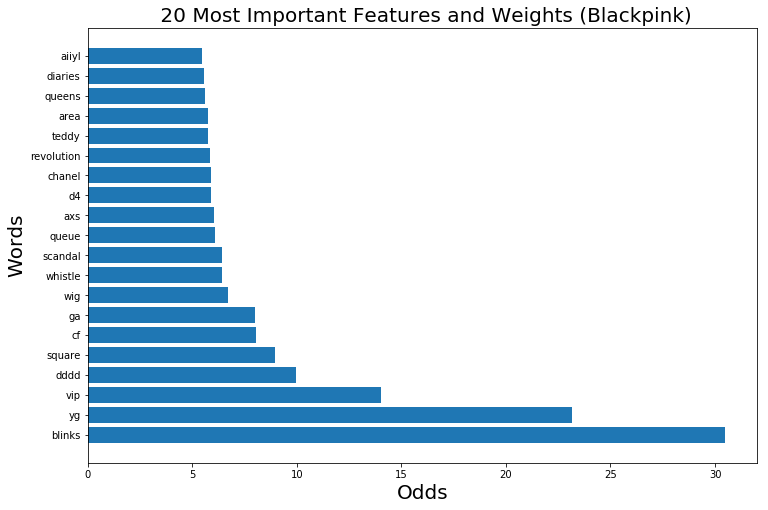

In [29]:
plt.figure(figsize=(12,8))
plt.barh(bp_top_20.index, bp_top_20)
plt.title(' 20 Most Important Features and Weights (Blackpink)', fontsize=20)
plt.xlabel('Odds', fontsize=20)
plt.ylabel('Words', fontsize=20)

# wig --> index:111
# ew --> ew cover / interview (positive feedbacks from fans)
# 134340 --> bts song pluto (fans love it due to a different feel from the norm, moves away from hiphop)

Blinks is the fandom name of Blackpink. On a subreddit of Blackpink, it makes complete sense that 'blinks' will be a very common term thrown around in comments from Blinks (BP fans). The words 'vip', 'ga', 'queue', and 'axs' all fit in the context of the upcoming concerts for Blackpink (VIP section, general area, ect). 

'DDDD' is the title track for Blackpink's last EP from last year (9 months ago). Based on some of the comments, we can see that many "Western" fans first grew to like Blackpink due to their songs like DDDD, which has strong western influences in terms of music genres (bubble-gum pop/rap & trap). These comments originate from a post on the subreddit where they discuss [Blackpink's U.S debut on Late Show with Stephen Colbert](https://www.reddit.com/r/BlackPink/comments/apra3j/190212_blackpink_ddudu_ddudu_the_late_show_with/) and though many fans express excitement over seeing their favorite group on a major U.S show, some feel as if Blackpink were not able to capitalize on capturing the average American's attention by putting on a weaker than normal performance (lip synching & lack of eccentric dance movements). Fortunately for some of the more concerned fans, Blackpink has another opportunity to perform on April 18 the [Late Late Show With James Corden](https://headlineplanet.com/home/2019/04/09/blackpink-scheduled-to-perform-on-april-18-late-late-show-with-james-corden/). We expect Blackpink to perform their newly released song that comes out on the 5th of April. Hopefully this new song contains elements similar to DDDD but with even more Western influences to capture the interest of many Americans watching the show. 


'Diaries' is referring to 'Blackpink Diaries' which is a short video series documenting parts of various activities of Blackpink members. It occasionally depicts what Blackpink members do in their off-time outside of their promotion periods as well as them bonding over going on vacations together and styling as a video blog format. Due to this format, many fans express excitement over seeing the members' bond and form a close unity on camera which creates for the viewers a form of connection to the Blackpink members on a more personal level.

In [483]:
print(f'DDDD comment: {df.body[8440]}')

DDDD comment: totally agree with this  dddd pwf whistle or even really are definitely the most western influenced and would ve been the best choices to introduce bp to the us  also agree that cute concepts wouldn t do well here  


In [484]:
print(f'DDDD comment: {df.body[8506]}')

DDDD comment: really wish they d let them perform some of their older songs  fy is an alright song but i don t think it s the best choice to debut bp to a western audience  after some of the reactions to their dddd performance  which i thought was a pretty solid song for western audiences   i m nervous how people will react to fy  i m just going to stay away from comment sections lol  


In [485]:
print(f'DDDD comment: {df.body[6089]}')

DDDD comment: yeah i wasnt a fan of dddd but i feel that people are way too aggressive with the bp hate  majority of things the girls have absolutely 0 control over so i dont get why people blame them 


In [491]:
print(f'Diaries comment: {df.body[910]}')

Diaries comment: such a cute episode  i liked seeing lisa and rose s bond and i hope in another episode they show jennie and jisoo  i m so looking forward to the next episode  these diaries have been so lovely to watch  i wonder if they ll release them on a box set or something in the future 


In [490]:
print(f'Diaries comment: {df.body[5339]}')

Diaries comment: i ve so been enjoying these diaries  i must say though i thought it was so cute with jisoo s bunny  when i was younger i went on more vacation trips with my parents and always had stuffed animals and yeah the hotel staff would always play around with it and making it look cute  i just loved her giggling over that and it brought back my own nice memories with it 


In [457]:
logreg_coef_df.T.sort_values('odds',ascending=True).head(20)

,odds
bighit,0.044649
army,0.048163
armys,0.080366
persona,0.083759
trailer,0.091177
bt21,0.102280
president,0.104901
bowl,0.112519
134340,0.129163
sope,0.129984


In [458]:
bts_top_20 = logreg_coef_df.T.sort_values('odds',ascending=True).head(20).odds
bts_top_20.index

Index(['bighit', 'army', 'armys', 'persona', 'trailer', 'bt21', 'president',
       'bowl', '134340', 'sope', 'mama', 'ot7', 'wembley', 'ew', 'run', 'nj',
       'soobin', 'bst', 'jk', 'handsome'],
      dtype='object')

Text(0, 0.5, 'Words')

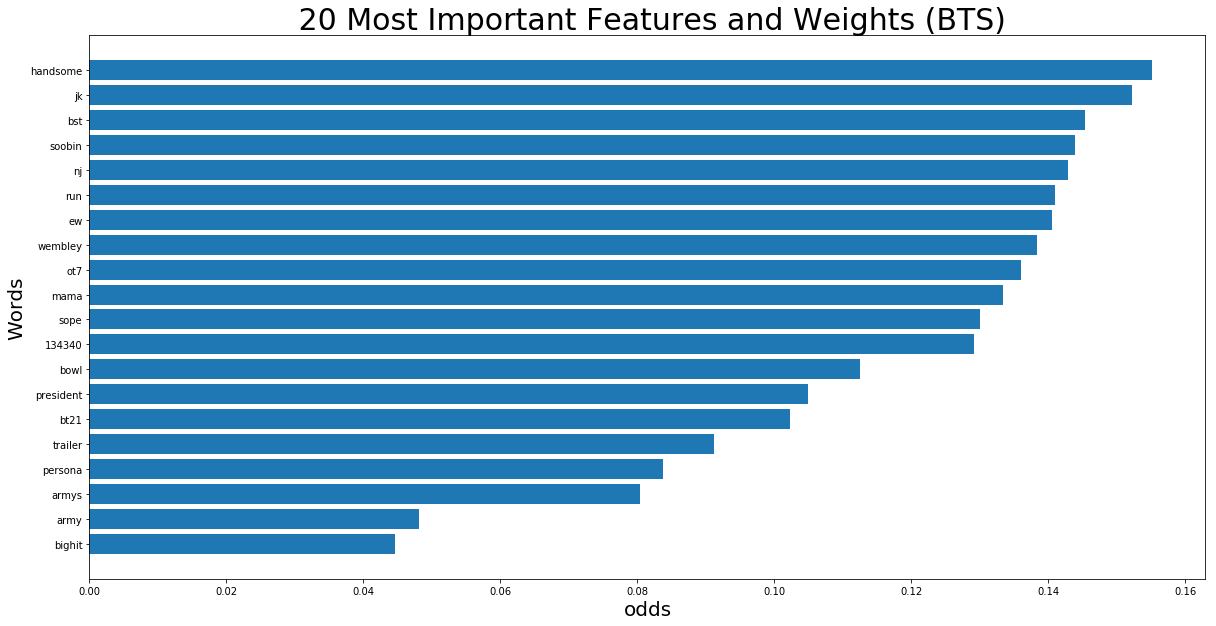

In [459]:
plt.figure(figsize=(20,10))
plt.barh(bts_top_20.index, bts_top_20)
plt.title(' 20 Most Important Features and Weights (BTS)', fontsize=30)
plt.xlabel('odds', fontsize=20)
plt.ylabel('Words', fontsize=20)

Armys is the fandom name of BTS. Much like the Blackpink example, it makes sense for 'armys' to be a common word in a subreddit of BTS filled with fans of BTS. 'Persona' is referring to 'Map of the Soul: Persona' which is the upcoming album expected to be released on April 12th. Overall, the fans seem to be very excited for the new songs from BTS. One comment in particular expects the production to be top notch and admires the fact that BTS experiments with different genres of music which helps them be more attractive to a wide-range of consumers. A lot of the fans also express admiration over their song '134340' which is an asteroid number assigned by scientists to the once-former planet, Pluto. According to this [article](https://www.hellokpop.com/kpop/korean-scientists-commend-bts-134340/), the group used the "sad news of Pluto losing its planetary status and moving away from the sun as a metaphor for loneliness and the feeling of abandonment." Examples like this are the reasons why many fans express respect towards BTS' artistry among most other kpop groups. 



In [497]:
print(f'BTS comment: {df.body.loc[14974]}')

BTS comment: 134340 is one of my favorite songs too  i m so glad they ll get to perform it  such an underrated song  


In [499]:
print(f'BTS comment: {df.body.loc[9623]}')

BTS comment: i trust that no matter what genre s  they put out  the production will be top notch  i m a huge fan of rock hip hop and persona was literally the embodiment of all my favorite music  but if they go with a different direction for the rest of the album  i ll still be happy  the majority of love yourself  tear sounded happy or poppy despite supposedly being a  depressing  album  134340  love maze  magic shop  anpanman  airplane pt  2  so what  the only songs that really matched the audible theme of tear was the intro  outro  title track and the truth untold  even through the tone of the songs were more poppy  the lyrics and meaning spoke for the concept  i have a feeling that map of the soul  persona will be the same way  most of the album being poppy other genres with a few of the tracks being more hiphop based  but all of them will have the  discovering and accepting all facets of yourself  meaning  title track wise  just like with fake love sounding both pop and emo  we ll

----

### Confusion Matrix

We will implement the confusion matrix in order to help us visualize  how our model performs. 
In terms of the classification metric we will use to measure performance, we will need to take a look into our positive and negative class. For this project, our positive class is "Blackpink" comments and the negative class is "Bts" comments. In respect to the problem statement at hand, it probably does not matter too much if we misclassify a comment from a Blackpink subreddit or BTS subreddit. Because we believe false positives and false negatives are equally as bad, we will continue to use accuracy as the classification metrix.

In [464]:
pred = logreg.predict(test_cvec_df)

In [465]:
confusion_matrix(y_test, pred)

array([[1795,  585],
       [ 515, 1789]])

In [467]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1795
False Positives: 585
False Negatives: 515
True Positives: 1789


What does a **true positive** mean here?:

- True positives are comments we correctly predict to be positive.
- In this case, since Blackpink = 1 (Bts=0), a true positive means the model correctly predicted 1,789 comments to be from the Blackpink subreddit.

---

What does a **true negative** mean here?:

- True negatives are comments we correctly predict to be negative.
- In this case, since Blackpink = 1 (Bts = 0), a true negative means the model correctly predicted 1,795 comments to be from the Bts subreddit.

---

What does a **false positive** mean here?:

- False positives are comments we falsely predict to be positive.
- In this case, since Blackpink = 1 (Bts = 0), a false positive means the model incorrectly predicted 585 comments to be from the Blackpink subreddit (when it's really from the Bts subreddit).

---

What does a **false negative** mean here?:

- False negatives are comments we false predict to be negative.
- In this case, since Blackpink = 1 (Bts=0), a false negative means the model incorrectly predicted 515 comments to be from the Bts subreddit (when it's really from the Blackpink subreddit).

## **Please continue to Notebook 05: Naive Bayes Model**